# Initialisation

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
from torch_geometric.data import Data
from torch_geometric.nn import GATConv

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


2.2.1+cu121


/tmp/ipykernel_11669/440843424.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
Dataframe_Labels = pd.read_csv("../BLCA_DATA/labels_str.csv")
Dataframe_link = pd.read_csv("../BLCA_DATA/CLINICAL/PROCESSED/patient_norm.csv")
Dataframe_node= pd.read_csv("../BLCA_DATA/node_embedding.csv")



Dataframe_Labels = Dataframe_Labels.rename(columns={'ID': 'Patient'})
Dataframe_link = Dataframe_link.rename(columns={'patient': 'Patient'})
Dataframe_node = Dataframe_node.rename(columns={'ID': 'Patient'})

# Nettoyage des dataframes pour qu'ils soient de la même longueur
Patients = set(Dataframe_node['Patient'])

# Filtrer les dataframes pour ne garder que les lignes avec les lettres communes
Dataframe_Labels = Dataframe_Labels[Dataframe_Labels['Patient'].isin(Patients)].reset_index(drop=True)
Dataframe_link = Dataframe_link[Dataframe_link['Patient'].isin(Patients)].reset_index(drop=True)

In [3]:
if os.path.exists("../BLCA_DATA/Workspace/labels_str.csv"):
  os.remove("../BLCA_DATA/Workspace/labels_str.csv")
  Dataframe_Labels.to_csv("../BLCA_DATA/Workspace/labels_str.csv",index=False)
else:
  Dataframe_Labels.to_csv("../BLCA_DATA/Workspace/labels_str.csv",index=False)

if os.path.exists("../BLCA_DATA/Workspace/patient_norm.csv"):
  os.remove("../BLCA_DATA/Workspace/patient_norm.csv")
  Dataframe_link.to_csv("../BLCA_DATA/Workspace/patient_norm.csv",index=False)
else:
  Dataframe_link.to_csv("../BLCA_DATA/Workspace/patient_norm.csv",index=False)

if os.path.exists("../BLCA_DATA/Workspace/node_embedding.csv"):
  os.remove("../BLCA_DATA/Workspace/node_embedding.csv")
  Dataframe_node.to_csv("../BLCA_DATA/Workspace/node_embedding.csv",index=False)
else:
  Dataframe_node.to_csv("../BLCA_DATA/Workspace/node_embedding.csv",index=False)

print("Dataframe_Labels, with length ", len(Dataframe_Labels), ":\n", Dataframe_Labels)
print("Dataframe_link, with length ", len(Dataframe_link), ":\n", Dataframe_link)
print("Dataframe_node, with length ", len(Dataframe_node), ":\n", Dataframe_node)

Dataframe_Labels, with length  404 :
           Patient        class
0    TCGA-2F-A9KO         LumP
1    TCGA-2F-A9KP         LumP
2    TCGA-2F-A9KQ         LumP
3    TCGA-2F-A9KR        Ba/Sq
4    TCGA-2F-A9KT        Ba/Sq
..            ...          ...
399  TCGA-ZF-AA56        Ba/Sq
400  TCGA-ZF-AA58        Ba/Sq
401  TCGA-ZF-AA5H        Ba/Sq
402  TCGA-ZF-AA5N         LumP
403  TCGA-ZF-AA5P  Stroma-rich

[404 rows x 2 columns]
Dataframe_link, with length  404 :
           Patient  days_to_birth  gender    height    weight  \
0    TCGA-2F-A9KO       0.470073     0.0  0.596491  0.095618   
1    TCGA-2F-A9KP       0.415682     0.0  0.824561  0.354582   
2    TCGA-2F-A9KQ       0.374778     0.0  0.508772  0.123506   
3    TCGA-2F-A9KR       0.542676     1.0  0.649123  0.155378   
4    TCGA-2F-A9KT       0.115820     0.0  0.719298  0.155378   
..            ...            ...     ...       ...       ...   
399  TCGA-ZF-AA56       0.193739     1.0  0.385965  0.087649   
400  TCGA-ZF-AA58 

# Visualisation

#### Mise en place d'un graphique

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

Patients = Dataframe_Labels["Patient"].tolist()
print(len(Patients))

# threshold to change
similarity_threshold = 0

404


/home/remax/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [5]:
patient_similarity = cosine_similarity(Dataframe_link.iloc[:, 1:])

df = pd.DataFrame(columns=["source_Patient", "source", "target_Patient", "target", "weight"])
row = 1
for i in range(patient_similarity.shape[0]):
    for j in range(i + 1, patient_similarity.shape[0]):
        if patient_similarity[i, j] > similarity_threshold:
            df.loc[row] = {"source_Patient" : Patients[i], "source":  i+1, "target_Patient" : Patients[j], "target":  j+1, "weight": patient_similarity[i][j]}
            row += 1
print(df)

In [ ]:
# Colors used to identify the subtypes on the graph
subtype_colors = { "LumP": "red", "Ba/Sq": "blue", "LumU": "green", "Stroma-rich": "purple", "LumNS": "orange", "NE-like": "pink"}

# Give the list of all the patient in the graph (ie, whom having at least a link > threshold)
combined_series = pd.concat([df['source_Patient'], df['target_Patient']])
unique_patients = combined_series.unique()

#print(unique_patients)

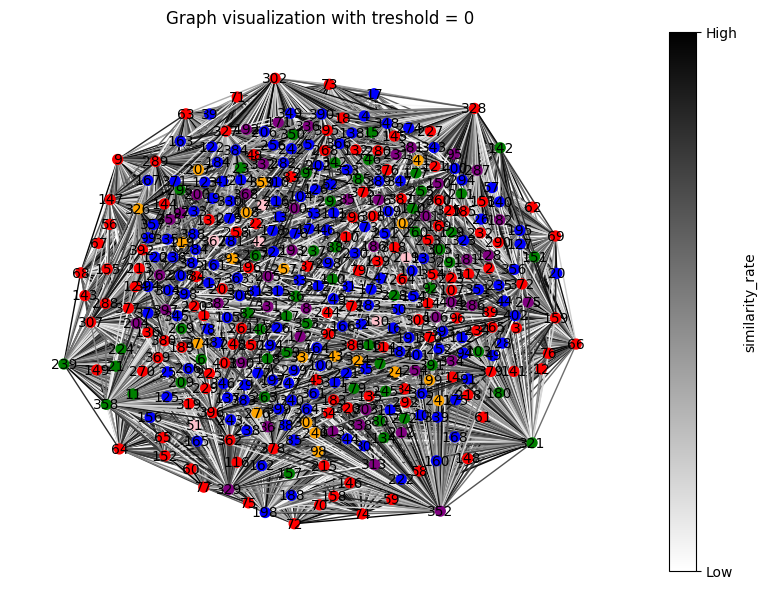

In [ ]:
G = nx.from_pandas_edgelist(df, 
                            source='source',
                            target='target',
                            edge_attr='weight',
                            create_using=nx.Graph())

# Give the characteristics of the nodes (ID, subtype, color)
nodes = [{node      : Patients[node - 1], 
          "subtype" : Dataframe_Labels[Dataframe_Labels['Patient'] == Patients[node - 1]]['class'].iloc[0],
          "color"   : subtype_colors[Dataframe_Labels[Dataframe_Labels['Patient'] == Patients[node - 1]]['class'].iloc[0]]
          } for node in G.nodes]
#print(nodes)

node_colors = []
for node in nodes: 
    node_colors.append(node["color"])


# def normalization function
def norm(shade):
    return (shade - similarity_threshold)/(1 - similarity_threshold)

# we must normalize the shades
edges_colors = [(norm(shade) * 255, norm(shade)* 255, norm(shade)* 255) for shade in df['weight']]

# Créer un ScalarMappable pour la colorbar
sm = plt.cm.ScalarMappable(cmap='gray_r', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])

# Créer les axes
fig, ax = plt.subplots(figsize=(10, 7))

# Positionner les nœuds
pos = nx.spring_layout(G, k=1.7)
options = {
    'node_color' : node_colors,
    'edge_color' : edges_colors,
    'node_size'  : 50,
    'with_labels': True,
    'font_size'  : 10,
    'font_color' : "black",
    'ax'         : ax  # Ajouter l'argument ax ici
}

# Dessiner le graphe
nx.draw(G, pos, **options)

# Ajouter la colorbar
cbar = fig.colorbar(sm, ax=ax, label="similarity_rate", orientation="vertical")
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Low', 'High'])
plt.title(f"Graph visualization with treshold = {similarity_threshold}", loc= 'center')

plt.show()